# Tiny ML Project  
## ROAD SIGN DETECTION

In [13]:
pip install tensorflow_model_optimization

## Importing required packages

In [14]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import math

In [15]:
#import stuff for Camera
import matplotlib.cm as cm
from IPython.display import Image

In [16]:
#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
#import pruning stuff
import tensorflow_model_optimization as tfmot

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.8.0


## Defining Earlystopping

In [18]:
#  define a callback

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                             patience = 15, 
                                             restore_best_weights = True)

## Building Data Generators

*  **In this cell, we are going to use ImageDataGenerator class from 
tensorflow library which Generate batches of tensor image data with real-time data augmentation. Using some arguments in the class, we can augument the data i.e creating some variations of images like flipping, rotating etc., which will yield better results when training the model for better accuracies.**
<br>
*  **Using this, we create both training and validation data.**

**Reference : Glodstein's Github <br>
      https://github.com/ebgoldstein/MokaPotNet/blob/main/src/MokaPotNet_portenta_sparse.ipynb**


In [19]:
#build data generators for training and validaton

split = 0.2

total_train = 3200
total_val = 800


# Define dirs and files
train_data_dir = '../data/'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range = 45,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 150

#set Image size (RGB so imshape is 3)
pix_dim = 320
imsize = (pix_dim,240) 
imshape = (pix_dim,240,1)


## Train data

In [20]:

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    color_mode = 'grayscale',
                                                    target_size = imsize,
                                                    subset='training')

Found 3200 images belonging to 8 classes.


## Validation data

In [21]:

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_directory(train_data_dir, # same directory as training data,
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical',
                                                        color_mode = 'grayscale',
                                                        target_size = imsize,
                                                        subset='validation')

Found 800 images belonging to 8 classes.


## Creating a CNN Model

*  **We created our model using the combination of 3 convolution layers and and 3 dense layers where the last dense layer is the output layer. We used the dropout of 50% to prevent overfitting of the model during training**

In [22]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=imshape),
    layers.Conv2D(filters=32, kernel_size=3, strides = 2, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Conv2D(64, 3, strides = 2, padding='same', activation='relu'),
    layers.MaxPool2D(),

    layers.Conv2D(64, 3, strides = 2, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8,activation = "softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 160, 120, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 80, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 30, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 8, 64)         36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 4, 64)        

## Compiling the model

In [23]:
#build the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = 'accuracy')

## Training the model

In [24]:
#train the model
history = model.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= 60,
                    validation_steps =  total_val // batch_size,
                    callbacks =[callbacks])

Epoch 1/60
21/21 [==============================] - 457s 22s/step - loss: 2.0796 - accuracy: 0.1325 - val_loss: 2.0743 - val_accuracy: 0.1507
Epoch 2/60
21/21 [==============================] - 71s 3s/step - loss: 2.0459 - accuracy: 0.1715 - val_loss: 1.9716 - val_accuracy: 0.2613
Epoch 3/60
21/21 [==============================] - 71s 3s/step - loss: 1.8939 - accuracy: 0.2259 - val_loss: 1.7658 - val_accuracy: 0.2800
Epoch 4/60
21/21 [==============================] - 75s 4s/step - loss: 1.7809 - accuracy: 0.2574 - val_loss: 1.7537 - val_accuracy: 0.2960
Epoch 5/60
21/21 [==============================] - 72s 3s/step - loss: 1.7404 - accuracy: 0.2872 - val_loss: 1.7610 - val_accuracy: 0.2680
Epoch 6/60
21/21 [==============================] - 72s 3s/step - loss: 1.7315 - accuracy: 0.2862 - val_loss: 1.7135 - val_accuracy: 0.3000
Epoch 7/60
21/21 [==============================] - 72s 3s/step - loss: 1.6723 - accuracy: 0.3121 - val_loss: 1.6042 - val_accuracy: 0.3533
Epoch 8/60
21/21 [

## Model Evaluation

In [49]:
model.evaluate(validation_generator)

6/6 [==============================] - 11s 2s/step - loss: 0.6192 - accuracy: 0.7887


[0.6192340850830078, 0.7887499928474426]

## Image representation of the model

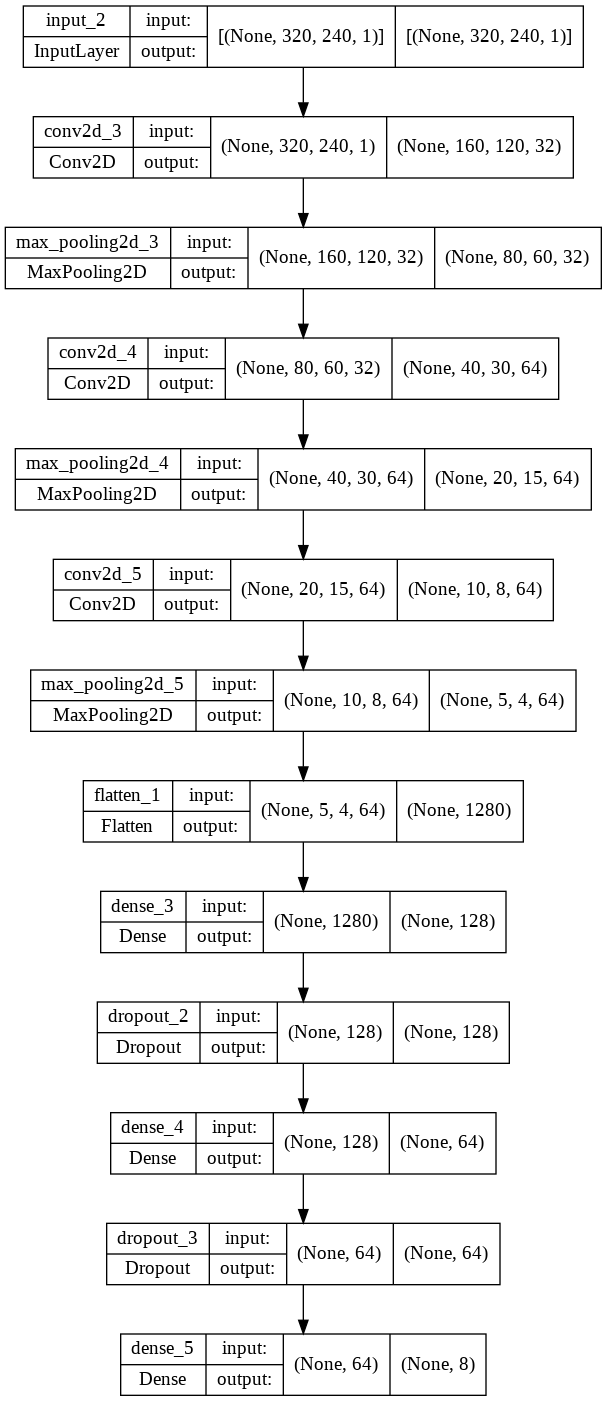

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

## Plotting Accuracy and Loss values

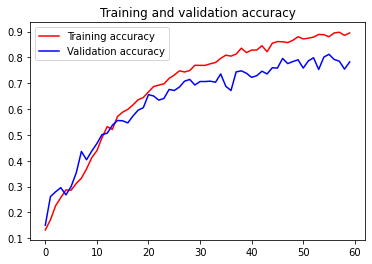

<Figure size 432x288 with 0 Axes>

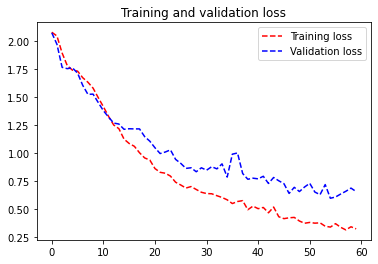

<Figure size 432x288 with 0 Axes>

In [26]:
#look at the metrics from training
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

## Saving the model

In [27]:
#save the model
filepath = '../model/Model'
model.save(filepath)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deployment/Model/assets


## Model Pruning

**Reference : Glodstein's Github <br>
      https://github.com/ebgoldstein/MokaPotNet/blob/main/src/MokaPotNet_portenta_sparse.ipynb**

In [37]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude


epochs = 10


end_step = np.ceil(1.0 * total_train / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.8,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)


/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


## Compiling the pruned model

In [38]:
# compile the pruned model.
model_for_pruning.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = 'accuracy')

model_for_pruning.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d_  (None, 160, 120, 32)     610       
 3 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 80, 60, 32)       1         
 ling2d_3 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_conv2d_  (None, 40, 30, 64)       36930     
 4 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 20, 15, 64)       1         
 ling2d_4 (PruneLowMagnitude                                     
 )                                                    

## Fitting on Pruned Model

In [39]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

phistory = model_for_pruning.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= 4,
                    validation_steps =  total_val // batch_size,
                    callbacks =callbacks)

Epoch 1/4
21/21 [==============================] - 79s 3s/step - loss: 0.7367 - accuracy: 0.7649 - val_loss: 0.7384 - val_accuracy: 0.7573
Epoch 2/4
21/21 [==============================] - 77s 4s/step - loss: 0.4788 - accuracy: 0.8472 - val_loss: 0.7525 - val_accuracy: 0.7373
Epoch 3/4
21/21 [==============================] - 76s 4s/step - loss: 0.4154 - accuracy: 0.8682 - val_loss: 0.7511 - val_accuracy: 0.7653
Epoch 4/4
21/21 [==============================] - 74s 4s/step - loss: 0.3851 - accuracy: 0.8784 - val_loss: 0.6474 - val_accuracy: 0.7747


## Pruned model evaluation

In [50]:
model_for_pruning.evaluate(validation_generator)

6/6 [==============================] - 10s 2s/step - loss: 0.6462 - accuracy: 0.7738


[0.6462448835372925, 0.7737500071525574]

## Plotting Pruned Accuracy and Loss

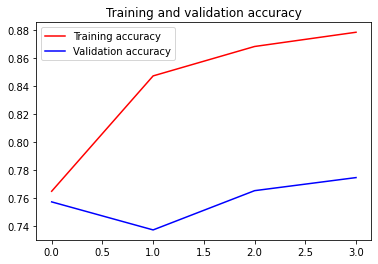

<Figure size 432x288 with 0 Axes>

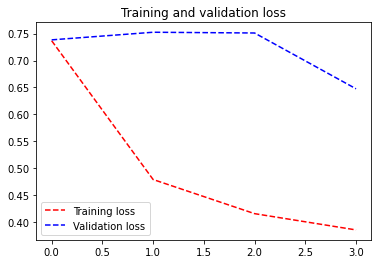

<Figure size 432x288 with 0 Axes>

In [40]:
#look at the metrics from training
%matplotlib inline

acc = phistory.history['accuracy']
val_acc = phistory.history['val_accuracy']
loss = phistory.history['loss']
val_loss = phistory.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

## Quantization of Pruned model and generating TFlite file

**Reference : Glodstein's Github <br>
      https://github.com/ebgoldstein/MokaPotNet/blob/main/src/MokaPotNet_portenta_sparse.ipynb**

In [47]:
# get the pruned model ready
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)



# quantize the model

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [48]:
# Representative dataset generation
num_calibration_steps = 1
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        x =np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
        print(x.shape)
        yield [x]
converter.representative_dataset = representative_dataset_gen

In [ ]:
tflite_model = converter.convert()

with open('../model/Road_QuantPruned.tflite','wb') as f:
    f.write(tflite_model)

interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

## Size of the final TFlite file

In [44]:
import os
import zipfile
import tempfile

def get_gzipped_model_size(file):
   #Returns size of gzipped model, in bytes.
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    return os.path.getsize(zipped_file)

In [46]:
print("Size of gzipped  Keras model: %.2f bytes" % (get_gzipped_model_size('../model/Model/saved_model.pb')))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size( '../model/Road_QuantPruned.tflite' )))

Size of gzipped  Keras model: 21805.00 bytes
Size of gzipped pruned and quantized TFlite model: 100486.00 bytes
